In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the pre-trained ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
model = model.to(device).eval()  # Set the model to evaluation mode

In [4]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Feature extraction function
def extract_features(image_path, model, transform):
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        with torch.no_grad():  # Disable gradient calculation for inference
            feature = model(image).cpu().numpy().flatten()  # Flatten the feature vector
        return feature
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [6]:
# Function to build the image index
def build_image_index(image_dir, metadata_file, model, transform):
    metadata = pd.read_csv(metadata_file)
    
    # Use the correct column for image filenames
    image_column = 'image_name'  # Update to match the column in your CSV
    if image_column not in metadata.columns:
        raise KeyError(f"Column '{image_column}' not found in metadata. Available columns: {metadata.columns.tolist()}")
    
    image_paths = [os.path.join(image_dir, image_name) for image_name in metadata[image_column]]
    
    features = []
    valid_paths = []
    for image_path in tqdm(image_paths, desc="Extracting Features"):
        if os.path.exists(image_path):
            feature = extract_features(image_path, model, transform)
            if feature is not None:
                features.append(feature)
                valid_paths.append(image_path)
        else:
            print(f"Image {image_path} not found. Skipping.")
    
    features = np.array(features)
    return valid_paths, features

In [7]:
# Function to retrieve similar images
def retrieve_similar_images(query_image_path, image_paths, features, top_k=5):
    query_feature = extract_features(query_image_path, model, transform).reshape(1, -1)
    # Compute cosine similarity between the query image and all images in the index
    similarities = cosine_similarity(query_feature, features).flatten()
    # Get top K most similar images
    top_indices = similarities.argsort()[::-1][:top_k]
    top_results = [(image_paths[idx], similarities[idx]) for idx in top_indices]
    return top_results

In [8]:
# Display Results
def display_results(results):
    for image_path, similarity in results:
        if os.path.exists(image_path):
            img = plt.imread(image_path)
            plt.imshow(img)
            plt.title(f"Similarity: {similarity:.2f}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Image {image_path} not found.")

Building image index...


Extracting Features: 100%|███████████████████████████████████████████████████████| 31783/31783 [41:12<00:00, 12.85it/s]


Retrieving similar images...
Displaying results...


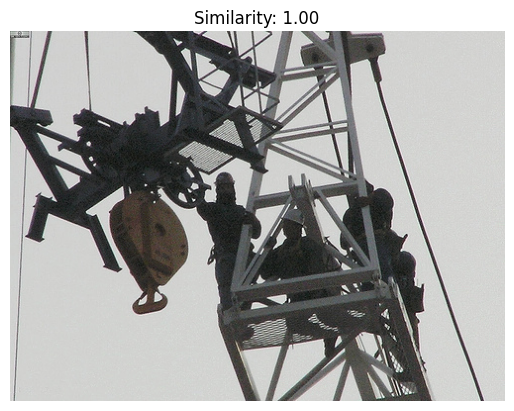

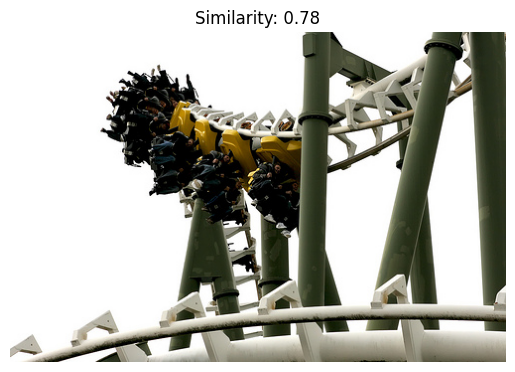

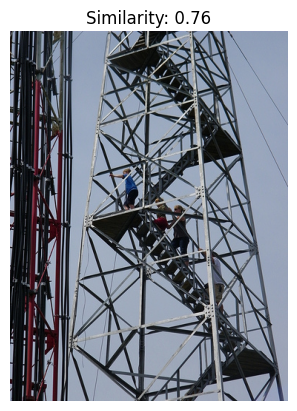

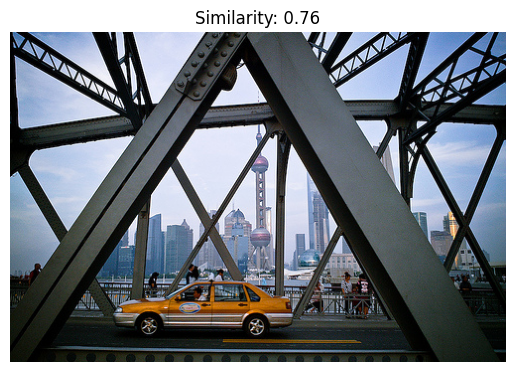

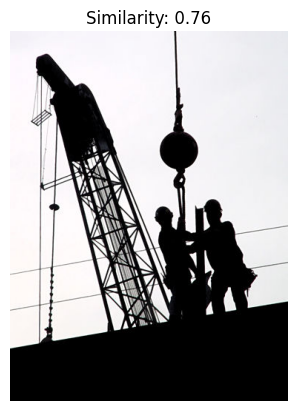

In [9]:
# Main
if __name__ == "__main__":
    image_dir = 'images'  # Directory containing images
    metadata_file = 'cleaned_results.csv'  # Metadata CSV file

    print("Building image index...")
    image_paths, features = build_image_index(image_dir, metadata_file, model, transform)

    query_image_path = 'images/10002456.jpg'  # Query image path
    if not os.path.exists(query_image_path):
        print(f"Query image {query_image_path} not found.")
    else:
        print("Retrieving similar images...")
        similar_images = retrieve_similar_images(query_image_path, image_paths, features, top_k=5)

        print("Displaying results...")
        display_results(similar_images)